# Telling birds from airplanes: Learning from images

## 7.1 A dataset of tiny images

`CIFAR-10` consists of 60,000 tiny 32 × 32 color (RGB) images, labeled with an integer corresponding to 1 of 10 classes: airplane (0), automobile (1), bird (2), cat (3),
deer (4), dog (5), frog (6), horse (7), ship (8), and truck (9)

In [1]:
### 7.1.1 Downloading CIFAR-10
from torchvision import datasets
data_path = 'data/p1ch6/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)
# https://docs.python.org/2/library/stdtypes.html#class.__mro__
type(cifar10).__mro__ 

Files already downloaded and verified
Files already downloaded and verified


(torchvision.datasets.cifar.CIFAR10,
 torchvision.datasets.vision.VisionDataset,
 torch.utils.data.dataset.Dataset,
 object)

In [2]:
### 7.1.2 The Dataset class

# when a Python object is equipped with the __len__ method, we can
# pass it as an argument to the len Python built-in function
len(cifar10), len(cifar10_val)

(50000, 10000)

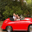

In [3]:
# since the dataset is equipped with the __getitem__ method, we can use the
# standard subscript for indexing tuples and lists to access individual items.
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
img, label = cifar10[99]
img, label, class_names[label]
img

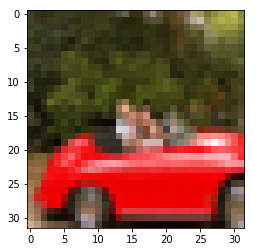

In [4]:
# Plot img
%matplotlib inline
from matplotlib import pyplot as plt
# plt.figure(dpi=300)
plt.imshow(img)
plt.show()

In [5]:
### 7.1.3 Dataset transforms

# torchvision transforms

from torchvision import transforms
# dir: https://www.runoob.com/python/python-func-dir.html
dir(transforms)

['CenterCrop',
 'ColorJitter',
 'Compose',
 'FiveCrop',
 'Grayscale',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'Pad',
 'RandomAffine',
 'RandomApply',
 'RandomChoice',
 'RandomCrop',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomOrder',
 'RandomPerspective',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSizedCrop',
 'RandomVerticalFlip',
 'Resize',
 'Scale',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'functional',
 'transforms']

In [6]:
# Let's try out the `ToTensor` transform
to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape

torch.Size([3, 32, 32])

In [7]:
# we can pass the transform directly as an argument to dataset.CIFAR10
cifar10_t = datasets.CIFAR10(data_path, train=True, download=True, 
                             transform=transforms.ToTensor())
# accessing an element of the dataset will return a tensor
img_t, _ = cifar10_t[99]
img_t.shape, img_t.dtype

Files already downloaded and verified


(torch.Size([3, 32, 32]), torch.float32)

In [8]:
# ToTensor transform turns the data into a 32-bit floating-point per channel,
# scaling the values down from 0.0 to 1.0.
# CxHxW
img_t.max(), img_t.min()

(tensor(1.), tensor(0.))

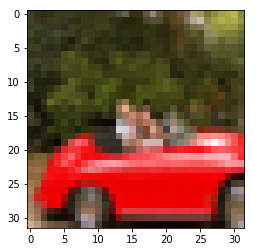

In [9]:
# Let's verify the image.
# Note how we have to use permute to change the order of the axes from
# C × H × W to H × W × C to match what Matplotlib expects.
plt.imshow(img_t.permute(1, 2, 0)) # From CxHxW to HxWxC to plt show
plt.show()

In [10]:
### 7.1.4 Normalizing data

# In order to make it so that each channel has zero mean and unitary standard deviation
#  v_n[c] = (v[c] - mean[c]) /stdev[c]. This is what transforms.Normalize does

#  Let's stack all the tensors.
import torch
imgs = torch.stack([img_t for img_t,_ in cifar10_t], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [11]:
# Now we can easily compute the mean & std per channel
mean = torch.mean(imgs.view(3, -1), dim=1)
std = torch.std(imgs.view(3, -1), dim=1)
mean, std

(tensor([0.4915, 0.4823, 0.4468]), tensor([0.2470, 0.2435, 0.2616]))

In [12]:
# Transform cifar10
transform_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.4915, 0.4823, 0.4468],
        std = [0.2470, 0.2435, 0.2616]
    )
])

transformed_cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
                                      transform=transform_cifar
                                     )
# val
transformed_cifar10_val = datasets.CIFAR10(data_path, train=False, download=False,
                                           transform=transform_cifar
                                          )


In [13]:
# Let's see the img again.
img_tn, _ = transformed_cifar10[99]
# img_tn
img_tn.shape, img_tn.dtype

(torch.Size([3, 32, 32]), torch.float32)

tensor([-1.0055, -1.1960, -1.2595, -1.2119, -1.0531, -1.0690, -1.0690, -1.1643,
        -1.0849, -1.1325, -1.0531, -1.0373, -0.9579, -0.6880, -0.4340, -1.1484,
        -1.1484, -0.4975,  0.3916, -0.4181, -0.7991, -0.6404, -0.2276, -0.0529,
         0.6774,  0.4551, -0.1958,  0.1852,  0.5504,  0.6615,  0.9156,  0.1852])


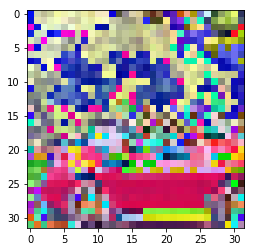

In [14]:
# converter to pil image.
img_pil = transforms.ToPILImage()(img_tn)
plt.imshow(img_pil)

# clip
print(img_tn[0][0])
# print(img_tn.dtype)
# plt.imshow(img_tn.permute(1, 2, 0)) # From CxHxW to HxWxC for plt show
plt.show()

## 7.2 Distinguishing birds from airplanes
We'll pick out all the birds and airplanes from our
CIFAR-10 dataset and build a neural network that can tell birds and airplanes apart

In [15]:
### 7.2.1 Building the dataset
class_names = ['airplane', 'bird']
remap_labels = {0: 0, 2: 1}  # airplane: 0, bird: 1

cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
                          transform=transform_cifar
                         )
cifar10_val = datasets.CIFAR10(data_path, train=True, download=False,
                               transform=transform_cifar
                              )

cifar2 = [(img, remap_labels[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val =[(img, remap_labels[label]) for img, label in cifar10_val if label in [0, 2]]

In [16]:
### 7.2.2 A fully connected model
import torch.nn as nn
n_out = 2  # numbers of classes.

model = nn.Sequential(
    nn.Linear(3072, 512),  # 32*32*3 = 3072
    nn.Tanh(),
    nn.Linear(512, n_out)
)
model

Sequential(
  (0): Linear(in_features=3072, out_features=512, bias=True)
  (1): Tanh()
  (2): Linear(in_features=512, out_features=2, bias=True)
)

In [17]:
### 7.2.3 Output of a classifier

# In the ideal case, the network would output torch.tensor([1.0, 0.0]) for an airplane 
# and torch.tensor([0.0, 1.0]) for a bird


In [18]:
### 7.2.4 Representing the output as probabilities

# Softmax
def softmax(x):
    return torch.exp(x)/torch.exp(x).sum()

# Test
x = torch.tensor([1.0, 2.0, 3.0])
softmax(x), softmax(x).sum()

(tensor([0.0900, 0.2447, 0.6652]), tensor(1.))

In [19]:
# The nn module makes softmax available as a module
softmax = nn.Softmax(dim=1) # along dim=1
x = torch.tensor([
    [1.0, 2.0, 3.0],
    [1.0, 2.0, 3.0],
])
softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

In [20]:
# We can now add a softmax at the end of our model, and our network
# will be equipped to produce probabilities
model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, n_out),
    nn.Softmax(dim=1)
)

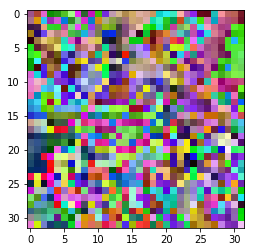

In [21]:
# build input batch.
img, _ = cifar2[0]
img_pil = transforms.ToPILImage()(img)
plt.imshow(img_pil)
plt.show()

In [22]:
# make batch
# So we need to turn our 3 × 32 × 32 image into a 1D tensor and then add an 
# extra dimension in the zeroth position.
img_batch = img.view(-1).unsqueeze(0)
out = model(img_batch)
out

tensor([[0.5151, 0.4849]], grad_fn=<SoftmaxBackward>)

In [23]:
### 7.2.5 A loss for classifying
# we want to penalize misclassifications 
# rather than painstakingly penalize everything that doesn't look exactly like 
# a 0.0 or 1.0

# it's called negative log likelihood (NLL). 
# It has the expression NLL = - sum(log(out_i[c_i]))


# nn.NLLLoss it does not take probabilities but rather takes a tensor of log probabilities as input
# We can now modify our model to use nn.LogSoftmax as the output module
model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, n_out),
    nn.LogSoftmax(dim=1)
    
)

# Loss
loss = nn.NLLLoss()


In [24]:
# We can now test it with our birdie.
img, label = cifar2[0]
print(label) # class indices.
out = model(img.view(-1).unsqueeze(0))
loss(out, torch.tensor([label]))

1


tensor(0.8489, grad_fn=<NllLossBackward>)

In [25]:
### 7.2.6 Training the classifier

# Train with minibatch=1, say per img.
learning_rate = 1e-2
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
n_epochs = 100
loss_fn = nn.NLLLoss()

# train use gpu
# device = torch.device('cuda')
# model = model.to(device)

# Training loop
def training_loop():
    for epoch in range(1, n_epochs):
        for img, label in cifar2:
            # train use gpu
    #         img = img.to(device)
    #         label = label.to(device)
            # Forward
            out = model(img.view(-1).unsqueeze(0))
            loss = loss_fn(out, torch.tensor([label]))
            # Optimizer
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Print loss per epoch
        print('epoch: %d, loss: %f' %(epoch, loss))

In [27]:
# The torch.utils.data module has a class that helps with shuffling and
# organizing the data in minibatches: DataLoader. 
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

# Training loop
def training_loop():
    for epoch in range(epochs):
        for imgs, labels in train_loader:
            # Forward
            batch_size = imgs.shape[0]
            out = model(imgs.view(batch_size, -1))
            # Loss
            loss = loss_fn(out, labels)
            # optim
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print('epoch: %d, loss: %f' %(epoch, loss))


In [31]:
# we can compute the accuracy of our model
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,shuffle=False)

correct = 0
total_samples = 0

with torch.no_grad(): # No grad
    for imgs, labels in val_loader:
        batch_size = imgs.shape[0]
        outs = model(imgs.view(batch_size, -1))
        # calc accuracy.
        total_samples += batch_size
        _, predicts = torch.max(outs, dim=1) # val_lists, indices
        correct += int((predicts == labels).sum())

    print('Accuracy: %f', correct/total_samples)


Accuracy: %f 0.4518


In [32]:
# The combination of nn.LogSoftmax and nn.NLLLoss is equivalent to using
# nn.CrossEntropyLoss.
model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, n_out)
)
loss_fn = nn.CrossEntropyLoss()


In [33]:
# PyTorch offers a quick way to determine how many parameters a model has
# through the parameters() method of nn.Model
numel_list = [p.numel()
              for p in model.parameters()
              if p.requires_grad == True
             ]
sum(numel_list), numel_list

(1574402, [1572864, 512, 1024, 2])

## Exercises

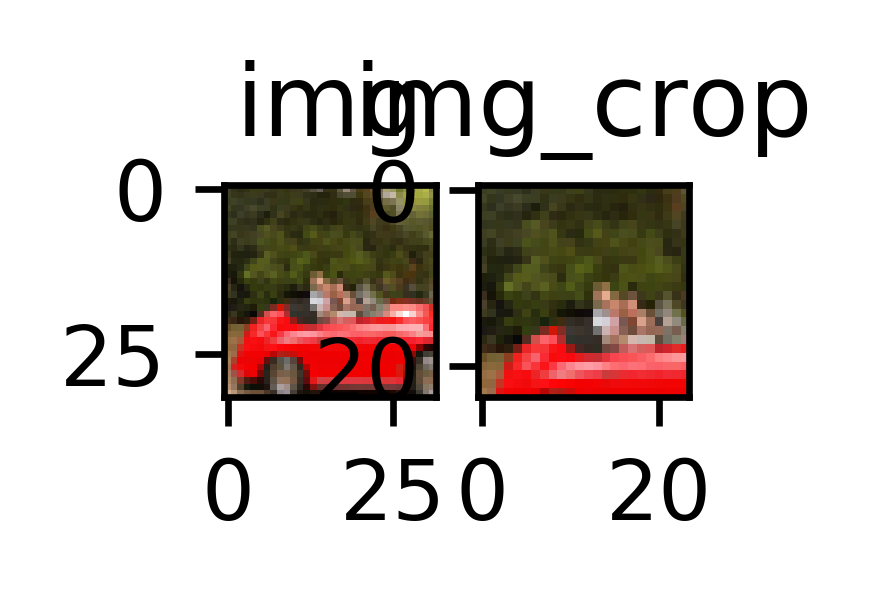

In [48]:
# Use torchvision to implement random cropping of the data.
# https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.RandomCrop

cifar10 = datasets.CIFAR10(data_path, train=True, download=False)

rand_crop = transforms.RandomCrop(24)
img, _ = cifar10[99]
img_crop = rand_crop(img)

imgs = [img, img_crop]
names = ['img', 'img_crop']
fig = plt.figure(figsize=(1, 2), dpi=600)
for i in range(2):
    ax = fig.add_subplot(1, 2, i+1)
    ax.set_title(names[i])
    plt.imshow(imgs[i])
plt.show()